## Tasks
Assigned to Sierra Stevenson, JSIP intern under Dr. Jonathan Jiang and Dr. Longtao Wu<p>
This analysis is intended to compare observed (MLS/AIRS/GPM_MERGIR) and simulated (UM) data to evaluate<br>how convection is resolved by storm-resolving models.

List of Tasks<p>
[DONE]&nbsp;&nbsp;&nbsp;Task 1 — UM moisture at 100 hPa map<br>
[DONE]&nbsp;&nbsp;&nbsp;Task 2 — MLS moisture at 100 hPa map<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 3 — UM/MLS/AIRS vert. profiles pressure vs temp/moisture<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 4 — UM/MLS PDFs (moisture)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 5 — UM/GPM_MERGIR PDFs (brightness temp)

UM (monthly): Task 1,2
MLS (monthly): Task 1,2

UM (hourly): Task 3-5
MLS (hourly): Task 3-5
AIRS (hourly): 

## Code
Setup

In [1]:
import metpy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy.stats as sst
import dask
import os
import glob
import below_god as bg
import seaborn as sns

from metpy.interpolate import log_interpolate_1d
from metpy.units import units
from netCDF4 import MFDataset, Dataset, num2date
from pydap.client import open_url

In [6]:
# Conversion factors
hPa_to_Pa = 100
kgkg_to_ppmv = 1.608 * 10 ** 6

MLS data

In [2]:
# Read L2 data using below_god
MLS_test = bg.io.read_l2gp('/data/emls/l2gp/v05.01/2016/225/MLS-Aura_L2GP-H2O_v05-01-c01_2016d225.he5')

In [3]:
path = "/data/emls/l2gp/v05.01/2016/"
yday_range = np.arange(224,252+1)   # 08/11 - 09/08 (double check)
# MLS_hrly_format = "{YDAY}/MLS-Aura_L2GP-H2O_v05-01-c01_2016d{YDAY}.he5"
# testfile = "/data/emls/l2gp/v05.01/2016/225/MLS-Aura_L2GP-H2O_v05-01-c01_2016d225.he5"

In [4]:
# Find min length of hourly data
lim = 4000
for day in yday_range:
    # print(day)
    if len(bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-H2O_v05-01-c01_2016d{day}.he5')['value']) < lim:
        lim = len(bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-H2O_v05-01-c01_2016d{day}.he5')['value'])

print(f"The minimum length of 'profile' values in the MLS L2 hourly datasets is {lim}.")

# Initialize xarray with first day
MLS_hrly = bg.io.read_l2gp('/data/emls/l2gp/v05.01/2016/224/MLS-Aura_L2GP-H2O_v05-01-c01_2016d224.he5')['value'][:lim]

# Fill in rest of hourly datasets
for day in yday_range:
    new = bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-H2O_v05-01-c01_2016d{day}.he5')['value'][:lim]
    MLS_hrly = xr.concat([MLS_hrly, new], dim='day')

The minimum length of 'profile' values in the MLS L2 hourly datasets is 3402.


In [8]:
# Select pressure = 100 hPa
MLS_h2o100_hrly = MLS_hrly.sel(lev=100.0) * kgkg_to_ppmv
np.save("MLS_h2o100_hrly",MLS_h2o100_hrly)

In [9]:
# Flatten data to get PDF
MLS_h2o100_hrly_flat = np.array(MLS_h2o100_hrly).ravel()
np.save("MLS_h2o100_hrly_flat",MLS_h2o100_hrly_flat)

AIRS data (yearly)

In [ ]:
# Starting with yearly
# TODO: When code is confirmed to work, set to daily and re-run after JPL work hours.

In [10]:
AIRS_file_names = []
AIRS_file1 = '/data/airs/AIRX3STD/v7/2003/AIRS.2003.08.15.L3.RetStd001.v7.0.3.0.G20202222706.hdf'
AIRS_data_yrly = xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset(AIRS_file1)))

yearly_AIRS = '/data/airs/AIRX3STD/v7/*/AIRS.*.08.15.L3.RetStd001.v7.0.3.0.*.hdf'
# daily_AIRS = '/data/airs/AIRX3STD/v7/*/AIRS.*.08.*.L3.RetStd001.v7.0.3.0.*.hdf'     # TODO: Include up to 09/08

print("Beginning loop. Runtime: 9 sec per file. (2 min for yearly data; 70 min for daily data.")

for file in glob.glob(yearly_AIRS):
    print(file)
    AIRS_file_names.append(file)
    AIRS_data_yrly = xr.concat([AIRS_data, xr.open_dataset(xr.backends.NetCDF4DataStore(Dataset(file)))], dim="time")

Beginning loop. Runtime: 9 sec per file. (2 min for yearly data; 70 min for daily data.
/data/airs/AIRX3STD/v7/2003/AIRS.2003.08.15.L3.RetStd001.v7.0.3.0.G20202222706.hdf
/data/airs/AIRX3STD/v7/2004/AIRS.2004.08.15.L3.RetStd001.v7.0.3.0.G20195222930.hdf
/data/airs/AIRX3STD/v7/2005/AIRS.2005.08.15.L3.RetStd001.v7.0.3.0.G20194175526.hdf
/data/airs/AIRX3STD/v7/2006/AIRS.2006.08.15.L3.RetStd001.v7.0.3.0.G20193130345.hdf
/data/airs/AIRX3STD/v7/2007/AIRS.2007.08.15.L3.RetStd001.v7.0.3.0.G20192120413.hdf
/data/airs/AIRX3STD/v7/2008/AIRS.2008.08.15.L3.RetStd001.v7.0.3.0.G20191235723.hdf
/data/airs/AIRX3STD/v7/2009/AIRS.2009.08.15.L3.RetStd001.v7.0.3.0.G20191120349.hdf
/data/airs/AIRX3STD/v7/2010/AIRS.2010.08.15.L3.RetStd001.v7.0.3.0.G20185230916.hdf
/data/airs/AIRX3STD/v7/2011/AIRS.2011.08.15.L3.RetStd001.v7.0.3.0.G20184153420.hdf
/data/airs/AIRX3STD/v7/2012/AIRS.2012.08.15.L3.RetStd001.v7.0.3.0.G20183101552.hdf
/data/airs/AIRX3STD/v7/2013/AIRS.2013.08.15.L3.RetStd001.v7.0.3.0.G20181235357.hdf

In [13]:
AIRS_data

<xarray.Dataset>
Dimensions:                              (time: 15, YDim:ascending: 180,
                                          XDim:ascending: 360,
                                          EmisFreqIR:ascending: 4,
                                          StdPressureLev:ascending: 24,
                                          H2OPressureLay:ascending: 12,
                                          H2OPressureLev:ascending: 12,
                                          ...
                                          StdPressureLev:ascending_MW_only: 24,
                                          YDim:descending_MW_only: 180,
                                          XDim:descending_MW_only: 360,
                                          EmisFreqMW:descending_MW_only: 3,
                                          StdPressureLev:descending_MW_only: 24,
                                          YDim:location: 180, XDim:location: 360)
Coordinates: (12/40)
  * XDim:ascending                       (XDim:ascending) float64 -180.0 ... ...
  * YDim:ascending                       (YDim:ascending) float64 90.0 ... -89.0
  * StdPressureLev:ascending             (StdPressureLev:ascending) float32 1...
  * EmisFreqIR:ascending                 (EmisFreqIR:ascending) float32 832.0...
  * CoarseCloudLayer:ascending           (CoarseCloudLayer:ascending) float32 ...
  * FineCloudLayer:ascending             (FineCloudLayer:ascending) float32 1...
    ...                                   ...
  * StdPressureLev:ascending_MW_only     (StdPressureLev:ascending_MW_only) float32 ...
  * EmisFreqMW:ascending_MW_only         (EmisFreqMW:ascending_MW_only) float32 ...
  * XDim:descending_MW_only              (XDim:descending_MW_only) float64 -1...
  * YDim:descending_MW_only              (YDim:descending_MW_only) float64 90...
  * StdPressureLev:descending_MW_only    (StdPressureLev:descending_MW_only) float32 ...
  * EmisFreqMW:descending_MW_only        (EmisFreqMW:descending_MW_only) float32 ...
Dimensions without coordinates: time, YDim:location, XDim:location
Data variables: (12/400)
    TotalCounts_A                        (time, YDim:ascending, XDim:ascending) float32 ...
    SurfPres_Forecast_A                  (time, YDim:ascending, XDim:ascending) float32 ...
    SurfPres_Forecast_A_ct               (time, YDim:ascending, XDim:ascending) float32 ...
    SurfPres_Forecast_A_sdev             (time, YDim:ascending, XDim:ascending) float32 ...
    SurfSkinTemp_A                       (time, YDim:ascending, XDim:ascending) float32 ...
    SurfSkinTemp_A_ct                    (time, YDim:ascending, XDim:ascending) float32 ...
    ...                                   ...
    TotCldLiqH2O_MW_D_ct                 (time, YDim:descending_MW_only, XDim:descending_MW_only) float32 ...
    TotCldLiqH2O_MW_D_sdev               (time, YDim:descending_MW_only, XDim:descending_MW_only) float32 ...
    Latitude                             (time, YDim:location, XDim:location) float32 ...
    Longitude                            (time, YDim:location, XDim:location) float32 ...
    LandSeaMask                          (time, YDim:location, XDim:location) float32 ...
    Topography                           (time, YDim:location, XDim:location) float32 ...
Attributes:
    HDFEOSVersion:                     HDFEOS_V2.18
    StructMetadata.0:                  GROUP=SwathStructure\nEND_GROUP=SwathS...
    StructMetadata.1:                  _FLOAT32\n\t\t\t\tDimList=("YDim","XDi...
    StructMetadata.2:                  ND_OBJECT=DataField_21\n\t\t\tOBJECT=D...
    identifier_product_doi:            10.5067/8XB4RU470FJV
    identifier_product_doi_authority:  http://dx.doi.org/
    coremetadata:                      \nGROUP                  = INVENTORYME...
    coremetadata.1:                    ://localhost/ftp/data/s4pa/.X9mnTjTGY0...
    coremetadata.2:                      OBJECT                 = OPERATIONMO...

In [12]:
np.save("AIRS_data_yrly", AIRS_data)

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

In [ ]:
AIRS_data = AIRS_data.mean(dim='time')

# Average ascending/descending temperature
AIRS_t_A = AIRS_data['Temperature_A'].mean(dim=['YDim:ascending', 'XDim:ascending', ])                              # Ascending orbit temperature
AIRS_t_D = AIRS_data['Temperature_D'].mean(dim=['YDim:descending', 'XDim:descending'])                              # Descending orbit temperature
AIRS_t = (AIRS_t_A.values + AIRS_t_D.values) / 2                                                                    # Average temperature
AIRS_t_prs = (AIRS_t_A['StdPressureLev:ascending'].values + AIRS_t_D['StdPressureLev:descending'].values) / 2       # Temperature-associated pressure

# Average ascending/descending moisture
AIRS_h2o_A = AIRS_data['H2O_MMR_A'].mean(dim=['YDim:ascending', 'XDim:ascending'])                                  # Ascending orbit moisture
AIRS_h2o_D = AIRS_data['H2O_MMR_D'].mean(dim=['YDim:descending', 'XDim:descending'])                                # Descending orbit moisture
AIRS_h2o = ((AIRS_h2o_A.values + AIRS_h2o_D.values) / 2) * kgkg_to_ppmv                                             # Average moisture
AIRS_h2o_prs = (AIRS_h2o_A['H2OPressureLev:ascending'].values + AIRS_h2o_D['H2OPressureLev:descending'].values) / 2 # Moisture-associated pressure
AIRS_h2o_prs = AIRS_h2o_prs

AIRS/MLS: Pressure vs. moisture/temperature

In [ ]:
# Find MLS data where pressure < 300 hPa
MLS_prs_idxs_under300 = np.where(MLS_prs * hPa_to_Pa <= (300 + 50), np.arange(len(MLS_prs)), np.nan)       # Get list of indexes where MLS pressure < 300 hPa
MLS_prs_idxs_under300 = MLS_prs_idxs_under300[~np.isnan(MLS_prs_idxs_under300)].astype(int)                # Remove NaNs and convert values to integers in list
MLS_h2o_under300 = MLS_h2o.mean(dim=['Lat','Lon'])[MLS_prs_idxs_under300]                                  # Get corresponding moisture values

# Find AIRS data where pressure >= 300 hPa
AIRS_prs_idxs_over300 = np.where(AIRS_h2o_prs >= 300, np.arange(len(AIRS_h2o_prs)), np.nan)               # Get list of indexes where AIRS pressure >= 300 hPa
AIRS_prs_idxs_over300 = AIRS_prs_idxs_over300[~np.isnan(AIRS_prs_idxs_over300)].astype(int)             # Remove NaNs and convert values to integers in list
AIRS_h2o_over300 = AIRS_h2o[AIRS_prs_idxs_over300]   

## Figures

Labels for plotting

In [ ]:
# All
date_range = "08/11/2016 — 09/08/2016"

# UM
UM_name = "Unified Model"

# MLS
MLS_dates = "08/2004 — 08/2022"
MLS_name = "MLS"

# GPM_MERGIR
GPM_name = "GPM_MERGIR Data"

Functions for figure creation

In [ ]:
def CreateVertProfile(arr, arr_prs, arr2=0, arr2_prs=None, data_label="Moisture", source="AIRS", source2="MLS", date_range=date_range, custom_units=None, full_AIRS=True):
    if data_label == "Moisture":
        units = "ppmv"
    elif data_label == "Temperature":
        units = "°C"
    else:
        units = custom_units
    plt.title(f"Vertical Profiles of Pressure (hPa) vs. {data_label} ({units})\nfrom {source} Data for {date_range}")
    plt.ylabel("Pressure (Pa)")
    plt.xlabel(f"{data_label} ({units})")
    plt.gca().invert_yaxis()

    plt.plot(arr, arr_prs, label=source, color="darkblue")

    if np.array(arr2).any() == True:
        plt.plot(arr2, arr2_prs, label=source2, color="orange")
        plt.legend()
    if full_AIRS == True:
        plt.plot(AIRS_h2o, AIRS_h2o_prs, label="AIRS (full)", zorder=-1, alpha=1, linewidth=2, linestyle="--", color="darkblue")
    plt.show()

Task 3: Vertical profiles of pressure vs. temperature/moisture (UM, MLS)

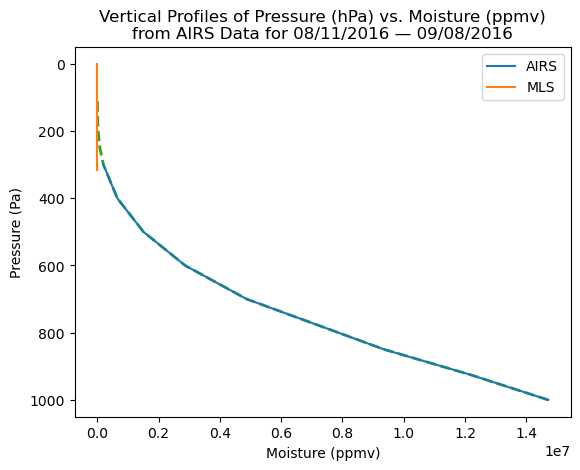

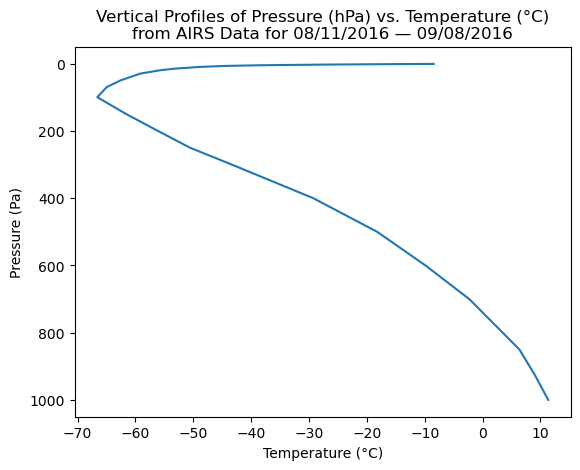

In [ ]:
# Pressure vs. Moisture (MLS/AIRS)
CreateVertProfile(AIRS_h2o_over300, AIRS_h2o_prs[AIRS_prs_idxs_over300], MLS_h2o_under300, MLS_prs[MLS_prs_idxs_under300] * hPa_to_Pa, full_AIRS=True)

# Pressure vs. Temperature  (AIRS)
CreateVertProfile(AIRS_t-273.15, AIRS_t_prs, data_label="Temperature")

KeyboardInterrupt: 

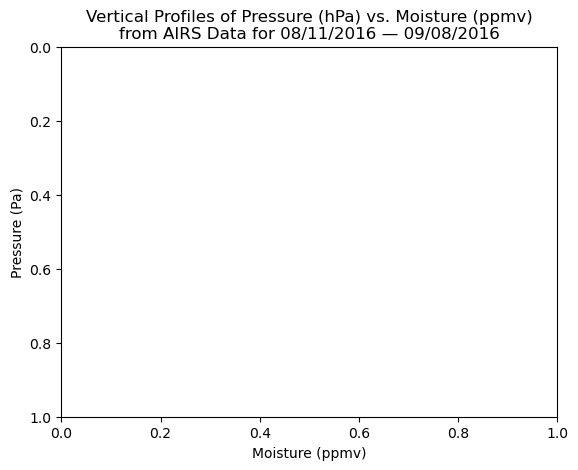

In [ ]:
# Pressure vs. Moisture (UM)
CreateVertProfile(UM_hus, UM_prs)

# Pressure vs. Temperature  (UM)
# CreateVertProfile(UM_ta-273.15, UM_prs, data_label="Temperature")

Task 4: PDFs of moisture at 100 hPa (UM, MLS)

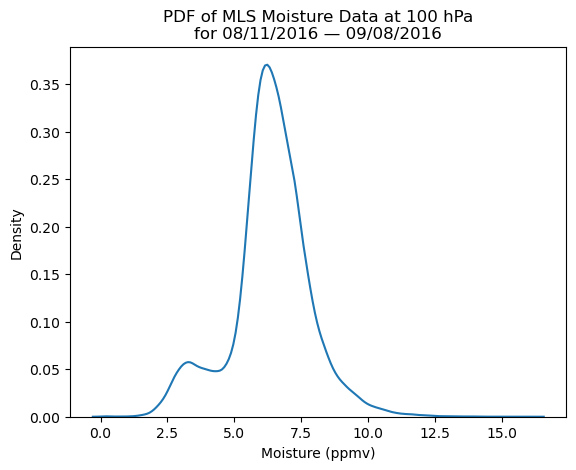

In [ ]:
# Moisture at 100 hPA PDF (MLS)
CreatePDF(MLS_h2o100_hrly_flat)

# TODO: Moisture at 100 hPA PDF (UM)
# CreatePDF(UM_h2o100_hrly_flat)

Task 5: PDFs of brightness temperature data (UM OLR, GPM_MERGIR)

In [ ]:
# TODO see task5 file